#  Importing libraries 

In [1]:
import pandas as pd 
import numpy as np 
import os 

C:\Users\Hassan Kerroumi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
for dirname, _, filenames in os.walk('Garbage_Classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# reading and processing data 
import cv2
import urllib 
import itertools 
import seaborn as sns 
import os, random, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen 

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

# model evaluation 
from sklearn.metrics import confusion_matrix, classification_report 

# modeling 

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.regularizers import l2

#  Load the dataset 

In [4]:
dir_path = '../../Datasets/Garbage_Classification/Garbage classification'

In [5]:
target_size = (224, 224)
waste_labels = {'cardboard':0, 'glass':1, 'metal':2, 'paper':3, 'plastic':4, 'trash':5}

In [6]:
def load_dataset(path):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(waste_labels[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return np.array(x), np.array(labels) 


In [7]:
x, labels = load_dataset(dir_path)

X size : (2527, 224, 224, 3)
Number of label classes [0 1 2 3 4 5], Number of observation in the dataset : 2527


In [8]:
dir_path2 = '../../Datasets/garbage_classification1'
x1, labels1 = load_dataset(dir_path2)

X size : (6283, 224, 224, 3)
Number of label classes [0 1 2 3 4 5], Number of observation in the dataset : 6283


In [9]:
AllData = np.concatenate([x, x1], axis=0)
allLabels = np.concatenate([labels, labels1], axis=0)

print(AllData.shape) 
print(allLabels.shape) 

(8810, 224, 224, 3)
(8810,)


In [10]:
input_shape = (np.array(AllData[0]).shape[1], np.array(AllData[0]).shape[0], 3)
print(input_shape)

(224, 224, 3)


In [11]:
np.array(list(list(waste_labels.keys())))

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# Sample from dataset

In [37]:
def visualize_img(image_batch, label_batch,n):
    """  Parameters:



  image_batch: Storing the matrix information of the images



  label_batch: A list that stores the class information of the image

    """
    plt.figure(figsize=(15,65))
    j = 0
    for n in range(100+n):
        ax = plt.subplot(20,5,j+1)
        j +=1
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys())) [to_categorical(labels, num_classes=6)[n]==1][0].title())

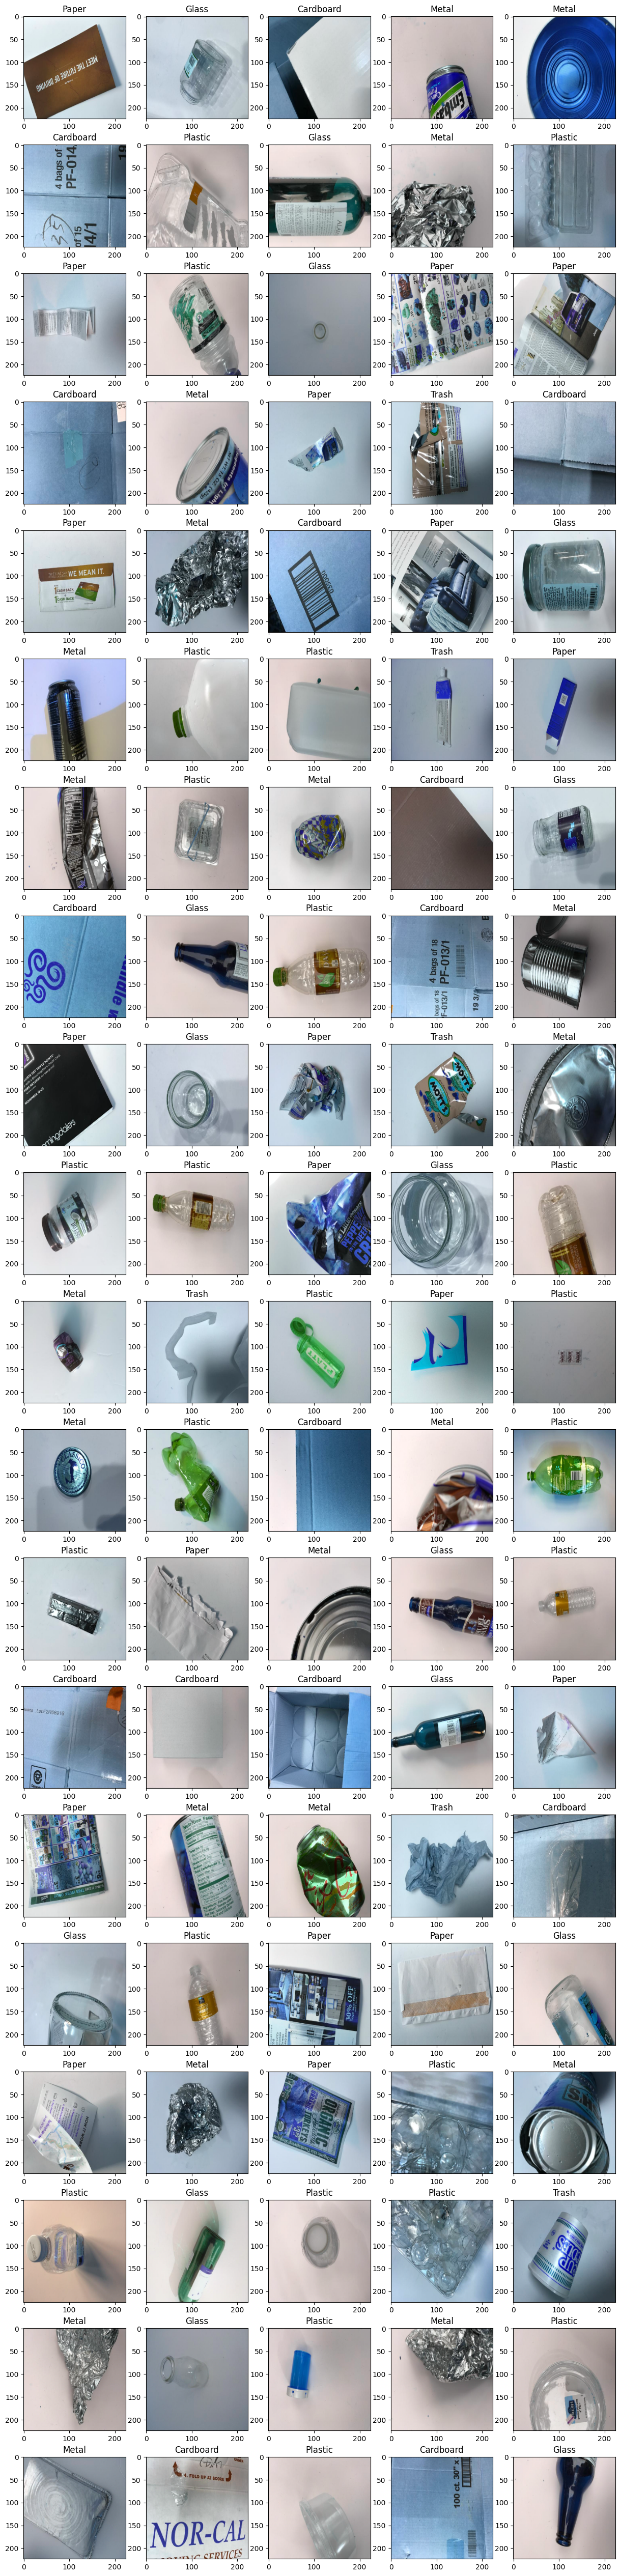

In [38]:
visualize_img(x, labels,0)

In [12]:
AllData, allLabels = shuffle(AllData, allLabels, random_state = 42)

In [13]:
from sklearn.model_selection import train_test_split
xtrain, temp_test, ytrain, ytemp_test = train_test_split(AllData, allLabels, test_size = 0.3, random_state = 42)

In [14]:
xtrain, temp_test = xtrain/255.0, temp_test/255.0

In [15]:
xval, xtest, yval, ytest = train_test_split(temp_test, ytemp_test, test_size = 0.5, random_state = 42)

In [16]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)
print(xval.shape, yval.shape)

(6167, 224, 224, 3) (6167,)
(1322, 224, 224, 3) (1322,)
(1321, 224, 224, 3) (1321,)


# Use VGG16 model to extract features 

In [17]:
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [18]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Assuming 'base_model' is the VGG16 model with 7x7x512 output
x = VGG_model.output  # Shape: (7, 7, 512)
x = GlobalAveragePooling2D()(x)  # Shape: (512,)
VGG16_model = Model(inputs=VGG_model.input, outputs=x)

# Get features from the model

In [20]:
Xtest_features = VGG16_model.predict(xtest)

42/42 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step


In [ ]:
Xtrain_features = VGG16_model.predict(xtrain)
Xtest_features = VGG16_model.predict(xtest)
xval_features = VGG16_model.predict(xval)

In [ ]:
NN_model = Sequential([
    Input(shape=(512,)),
    Dense(units = 500, activation = "relu"),
    Dropout(0.6),
    Dense(units = 128, activation = "relu"),
    Dropout(0.3),
    Dense(units = 64, activation = "relu"),
    Dropout(0.3),
    Dense(units = 32, activation = "relu"),
    Dense(units = 6, activation = "softmax"),

])

In [ ]:
NN_model.summary()

# Train the model

In [ ]:
NN_model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [83]:
callbacks = [EarlyStopping(monitor='val_accuracy',

                           patience=100,

                           verbose=1,

                           mode="max"),



             ModelCheckpoint(filepath='Res_Model_3.keras',

                             monitor='val_accuracy',
                             mode='max',

                             save_best_only=True,

                             save_weights_only=False,

                             verbose=1)]

In [84]:
PreTrained_history = NN_model.fit(Xtrain_features, ytrain, epochs = 1000,callbacks = callbacks, validation_data=(xval_features, yval) )

Epoch 1/1000
181/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2879 - loss: 1.7185
Epoch 1: val_accuracy improved from -inf to 0.52460, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2930 - loss: 1.7080 - val_accuracy: 0.5246 - val_loss: 1.1543
Epoch 2/1000
186/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5050 - loss: 1.2184
Epoch 2: val_accuracy improved from 0.52460 to 0.58289, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5058 - loss: 1.2168 - val_accuracy: 0.5829 - val_loss: 0.9883
Epoch 3/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5619 - loss: 1.0860
Epoch 3: val_accuracy improved from 0.58289 to 0.63134, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5623 - loss: 1.0854 - val_accuracy: 0.6313 - val_loss: 0.8856
Epoch 4/1000
186/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6144 - loss: 0.9832
Epoch 4: val_accuracy improved

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8217 - loss: 0.5081 - val_accuracy: 0.8448 - val_loss: 0.4653
Epoch 25/1000
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8353 - loss: 0.4674
Epoch 25: val_accuracy did not improve from 0.84860
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8352 - loss: 0.4677 - val_accuracy: 0.8403 - val_loss: 0.4563
Epoch 26/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8254 - loss: 0.4972
Epoch 26: val_accuracy did not improve from 0.84860
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8254 - loss: 0.4972 - val_accuracy: 0.8433 - val_loss: 0.4610
Epoch 27/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8272 - loss: 0.4858
Epoch 27: val_accuracy improved from 0.84860 to 0.86298, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8278 - loss: 0.4847 - val_accuracy: 0.8630 - val_loss: 0.4571
Epoch 28/1000
185/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8

Epoch 74/1000
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9022 - loss: 0.2872
Epoch 74: val_accuracy did not improve from 0.89478
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9021 - loss: 0.2873 - val_accuracy: 0.8804 - val_loss: 0.4130
Epoch 75/1000
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8836 - loss: 0.3321
Epoch 75: val_accuracy did not improve from 0.89478
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8837 - loss: 0.3317 - val_accuracy: 0.8864 - val_loss: 0.3971
Epoch 76/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9046 - loss: 0.2679
Epoch 76: val_accuracy did not improve from 0.89478
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9045 - loss: 0.2686 - val_accuracy: 0.8910 - val_loss: 0.4220
Epoch 77/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9088 - loss: 0.2689
Epoch 77: val_accuracy did not improve from 0.89478
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9087 - loss: 0.2690 - val_accu

Epoch 99/1000
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9220 - loss: 0.2221
Epoch 99: val_accuracy did not improve from 0.90613
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9219 - loss: 0.2223 - val_accuracy: 0.9008 - val_loss: 0.4130
Epoch 100/1000
183/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9133 - loss: 0.2576
Epoch 100: val_accuracy did not improve from 0.90613
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9130 - loss: 0.2578 - val_accuracy: 0.8933 - val_loss: 0.3882
Epoch 101/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9160 - loss: 0.2392
Epoch 101: val_accuracy did not improve from 0.90613
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9158 - loss: 0.2402 - val_accuracy: 0.9016 - val_loss: 0.3849
Epoch 102/1000
180/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9099 - loss: 0.2641
Epoch 102: val_accuracy did not improve from 0.90613
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9099 - loss: 0.2640 - va

Epoch 124/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9225 - loss: 0.2120
Epoch 124: val_accuracy did not improve from 0.91067
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9226 - loss: 0.2120 - val_accuracy: 0.9084 - val_loss: 0.3977
Epoch 125/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.2414
Epoch 125: val_accuracy improved from 0.91067 to 0.91522, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9156 - loss: 0.2412 - val_accuracy: 0.9152 - val_loss: 0.4153
Epoch 126/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9270 - loss: 0.2172
Epoch 126: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9270 - loss: 0.2173 - val_accuracy: 0.9023 - val_loss: 0.4237
Epoch 127/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9330 - loss: 0.2030
Epoch 127: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

Epoch 149/1000
181/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9282 - loss: 0.2026
Epoch 149: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9285 - loss: 0.2024 - val_accuracy: 0.9084 - val_loss: 0.4218
Epoch 150/1000
180/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9361 - loss: 0.1835
Epoch 150: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9361 - loss: 0.1841 - val_accuracy: 0.9039 - val_loss: 0.4281
Epoch 151/1000
184/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9270 - loss: 0.2158
Epoch 151: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9271 - loss: 0.2153 - val_accuracy: 0.9099 - val_loss: 0.4193
Epoch 152/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9270 - loss: 0.2058
Epoch 152: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9271 - loss: 0.2055 - 

Epoch 174/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9310 - loss: 0.1941
Epoch 174: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9310 - loss: 0.1941 - val_accuracy: 0.9107 - val_loss: 0.4396
Epoch 175/1000
180/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9358 - loss: 0.1973
Epoch 175: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9360 - loss: 0.1965 - val_accuracy: 0.9054 - val_loss: 0.4078
Epoch 176/1000
187/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9382 - loss: 0.1963
Epoch 176: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9380 - loss: 0.1961 - val_accuracy: 0.9092 - val_loss: 0.4125
Epoch 177/1000
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9396 - loss: 0.1859
Epoch 177: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9395 - loss: 0.1858 - 

Epoch 199/1000
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9456 - loss: 0.1595
Epoch 199: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9453 - loss: 0.1602 - val_accuracy: 0.9092 - val_loss: 0.3981
Epoch 200/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9443 - loss: 0.1624
Epoch 200: val_accuracy did not improve from 0.91522
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9443 - loss: 0.1624 - val_accuracy: 0.9084 - val_loss: 0.4257
Epoch 201/1000
183/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9388 - loss: 0.1738
Epoch 201: val_accuracy improved from 0.91522 to 0.91824, saving model to Res_Model_3.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9385 - loss: 0.1741 - val_accuracy: 0.9182 - val_loss: 0.4242
Epoch 202/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.1427
Epoch 202: val_accuracy did not improve from 0.91824
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

Epoch 224/1000
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1409
Epoch 224: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9511 - loss: 0.1410 - val_accuracy: 0.9069 - val_loss: 0.4585
Epoch 225/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9487 - loss: 0.1478
Epoch 225: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9487 - loss: 0.1479 - val_accuracy: 0.9084 - val_loss: 0.4503
Epoch 226/1000
184/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9369 - loss: 0.1798
Epoch 226: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9370 - loss: 0.1794 - val_accuracy: 0.9137 - val_loss: 0.4445
Epoch 227/1000
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9447 - loss: 0.1487
Epoch 227: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9447 - loss: 0.1489 - 

Epoch 249/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9431 - loss: 0.1501
Epoch 249: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9431 - loss: 0.1501 - val_accuracy: 0.9182 - val_loss: 0.4565
Epoch 250/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9497 - loss: 0.1445
Epoch 250: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9497 - loss: 0.1446 - val_accuracy: 0.9137 - val_loss: 0.4484
Epoch 251/1000
186/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9368 - loss: 0.1742
Epoch 251: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9371 - loss: 0.1735 - val_accuracy: 0.9160 - val_loss: 0.4574
Epoch 252/1000
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9452 - loss: 0.1465
Epoch 252: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9452 - loss: 0.1467 - 

Epoch 274/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9531 - loss: 0.1248
Epoch 274: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9531 - loss: 0.1248 - val_accuracy: 0.9069 - val_loss: 0.4983
Epoch 275/1000
183/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9502 - loss: 0.1469
Epoch 275: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9502 - loss: 0.1469 - val_accuracy: 0.9092 - val_loss: 0.5009
Epoch 276/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9537 - loss: 0.1376
Epoch 276: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9537 - loss: 0.1376 - val_accuracy: 0.9152 - val_loss: 0.4708
Epoch 277/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1421
Epoch 277: val_accuracy did not improve from 0.91976
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9510 - loss: 0.1422 - 

Epoch 299/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9465 - loss: 0.1415
Epoch 299: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9465 - loss: 0.1415 - val_accuracy: 0.9175 - val_loss: 0.4272
Epoch 300/1000
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9561 - loss: 0.1242
Epoch 300: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9560 - loss: 0.1244 - val_accuracy: 0.9198 - val_loss: 0.4569
Epoch 301/1000
184/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9552 - loss: 0.1324
Epoch 301: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1324 - val_accuracy: 0.9145 - val_loss: 0.5238
Epoch 302/1000
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9557 - loss: 0.1269
Epoch 302: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9556 - loss: 0.1272 - 

Epoch 324/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9614 - loss: 0.1085
Epoch 324: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9613 - loss: 0.1091 - val_accuracy: 0.9182 - val_loss: 0.4457
Epoch 325/1000
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9507 - loss: 0.1314
Epoch 325: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9507 - loss: 0.1314 - val_accuracy: 0.9084 - val_loss: 0.5012
Epoch 326/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9620 - loss: 0.1065
Epoch 326: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9619 - loss: 0.1066 - val_accuracy: 0.9228 - val_loss: 0.5079
Epoch 327/1000
182/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - loss: 0.1377
Epoch 327: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9527 - loss: 0.1362 - 

Epoch 349/1000
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9477 - loss: 0.1450
Epoch 349: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9478 - loss: 0.1448 - val_accuracy: 0.9061 - val_loss: 0.5158
Epoch 350/1000
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9576 - loss: 0.1188
Epoch 350: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9576 - loss: 0.1188 - val_accuracy: 0.9122 - val_loss: 0.5209
Epoch 351/1000
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9552 - loss: 0.1325
Epoch 351: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9552 - loss: 0.1324 - val_accuracy: 0.9152 - val_loss: 0.5052
Epoch 352/1000
184/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9576 - loss: 0.1145
Epoch 352: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9574 - loss: 0.1150 - 

Epoch 374/1000
180/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9581 - loss: 0.1228
Epoch 374: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9581 - loss: 0.1225 - val_accuracy: 0.9107 - val_loss: 0.5137
Epoch 375/1000
185/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.1182
Epoch 375: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9629 - loss: 0.1180 - val_accuracy: 0.9114 - val_loss: 0.5481
Epoch 376/1000
185/193 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9618 - loss: 0.1041
Epoch 376: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9618 - loss: 0.1042 - val_accuracy: 0.9137 - val_loss: 0.5378
Epoch 377/1000
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9612 - loss: 0.1124
Epoch 377: val_accuracy did not improve from 0.92430
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9612 - loss: 0.1125 - 

# Test

In [85]:
Xtest_features.shape

(1322, 512)

In [27]:
pred = NN_model.predict(Xtest_features)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# Evaluation 

In [ ]:
plt.plot(PreTrained_history.history['accuracy'], label='accuracy')
plt.plot(PreTrained_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = NN_model.evaluate(Xtest_features,  ytest, verbose=2)

In [23]:
NN_model = load_model("Res_Model_3.keras")
test_loss, test_acc = NN_model.evaluate(Xtest_features,  ytest, verbose=2)

42/42 - 0s - 11ms/step - accuracy: 0.9221 - loss: 0.4148


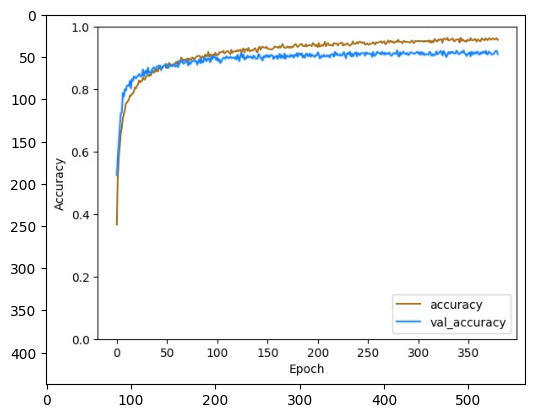

In [23]:
plt.imshow(cv2.imread("accudataau.jpg"))

# Plot ROC and DET curves 

In [72]:
from sklearn.preprocessing import label_binarize


def evaluate(ytrue, ypred):
    acc = 0
    m = ytrue.shape[0]
    for i in range(m):
        if ytrue[i] == ypred[i]:
            acc += 1 
    return acc/m

def CourbeROC(y_pred_binarise, y_proba):
    # Initialisation des variables
    seuil = np.max(y_proba) + 0.01 if np.max(y_proba) != 1 else 1
    pas = seuil / y_pred_binarise.shape[0]  # Calcul du pas
    mins = np.min(y_proba)
    pos = max(1, len(y_pred_binarise[y_pred_binarise == 1]))
    neg = max(1, len(y_pred_binarise[y_pred_binarise == 0]))
    
    # TPR (True Positive Rate) et FPR (False Positive Rate)
    TPR = []
    FPR = []
    seuils = []
    
    # Calcul de TPR et FPR pour différents seuils
    while seuil > mins:
        TPR.append(len(y_pred_binarise[(y_pred_binarise == 1) & (y_proba >= seuil)]) / pos)
        FPR.append(len(y_pred_binarise[(y_pred_binarise == 0) & (y_proba >= seuil)]) / neg)
        seuils.append(seuil)
        seuil -= pas
    return TPR, FPR

def roc_class(y_true,y_proba1,n_classes = 6,labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']):

    y_pred = np.argmax(y_proba1,axis = 1)
    # Binarize the true labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Initialize plots
    plt.figure(figsize=(7, 7))

    # ROC Curve
    for i in range(n_classes):
        # Compute ROC curve and AUC for each class
        class_mask = (y_true == i)  # Boolean mask for selecting samples of class i
        ytrue_class = y_true[class_mask]
        ypred_class = y_pred[class_mask]

        # Apply evaluate function to the current class
        acc = evaluate(ytrue_class, ypred_class)
        tpr, fpr = CourbeROC(y_true_bin[:, i], y_proba1[:, i])
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {acc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    plt.title('ROC Curve for model 1 with 512 features after data augmentation')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid()

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import norm
from sklearn.preprocessing import label_binarize

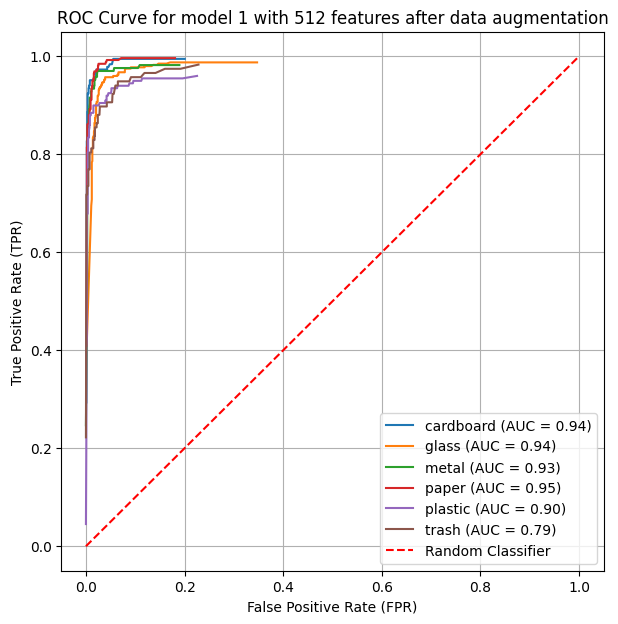

In [74]:
roc_class(ytest,pred)

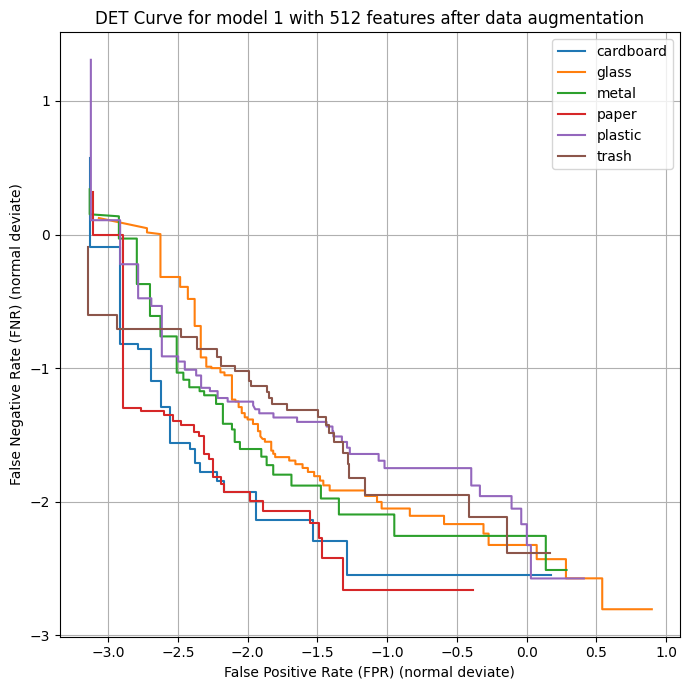

In [94]:
# DET Curve
plt.figure(figsize=(7, 7))
for i in range(n_classes):
    # Compute ROC curve (to get FPR and TPR)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred[:, i])
    fnr = 1 - tpr  # Compute False Negative Rate

    # Transform FPR and FNR to normal deviates
    fpr_norm = norm.ppf(fpr)
    fnr_norm = norm.ppf(fnr)

    # Handle invalid values (due to ppf on 0 or 1)
    fpr_norm[np.isinf(fpr_norm)] = np.nan
    fnr_norm[np.isinf(fnr_norm)] = np.nan

    plt.plot(fpr_norm, fnr_norm, label=labels[i])

plt.title('DET Curve for model 1 with 512 features after data augmentation')
plt.xlabel('False Positive Rate (FPR) (normal deviate)')
plt.ylabel('False Negative Rate (FNR) (normal deviate)')
plt.grid(which='both')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# test in real time

In [33]:
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [6]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Assuming 'base_model' is the VGG16 model with 7x7x512 output
x = VGG_model.output  # Shape: (7, 7, 512)
x = GlobalAveragePooling2D()(x)  # Shape: (512,)
VGG16_model = Model(inputs=VGG_model.input, outputs=x)

In [22]:
from tensorflow.keras.models import load_model

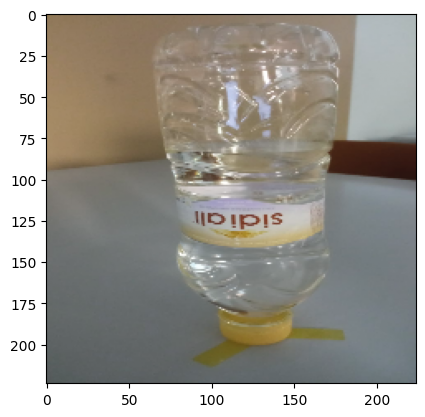

In [34]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
img_x = []
m = load_model("../Models/Res_Model_3.keras")
img = cv2.imread("../imagesTest/plas2.jpg")
img = cv2.resize(img, (224,224)) / 255.0
img_x.append(img)
img_x = np.array(img_x)
img_x.shape
plt.imshow(img)

In [36]:
s  = VGG16_model.predict(img_x)

y_pred = m.predict(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [37]:
y_pred

array([[5.7148810e-07, 3.5208889e-04, 1.3185578e-06, 1.0098737e-06,
        9.9933630e-01, 3.0868681e-04, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [38]:
predicted_class_index = np.argmax(y_pred)

predicted_label = next((key for key, value in waste_labels.items() if value == predicted_class_index), None)

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_label}")

Predicted class index: 4
Predicted class name: plastic


In [ ]:
new_path "Garbage_Classification_splited/Test"
new_x, new_labels = load_dataset

# Graphical interface 

In [3]:
from tensorflow.keras.models import load_model

model = load_model("../Models/Res_Model_3.keras")

In [2]:
from PySide6.QtWidgets import QApplication, QWidget, QMainWindow, QFrame, QHBoxLayout, QSizePolicy, QMenu, QFileDialog,QDialog, QToolBar, QStatusBar, QPushButton, QLabel, QVBoxLayout
from PySide6.QtGui import QAction, QIcon, QPixmap, QFont, QColor, QPalette, QImage, QMovie
from PySide6.QtCore import QSize, Qt
import sys
import cv2
import numpy as np
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model("../Models/Res_Model_3.keras")
class MainWindow(QMainWindow ):
   

    def __init__(self, app):
        super().__init__()
        
        self.app = app # declare app member 
        #--------------------Font---------------------------------
        self.current_image = None
        self.setWindowTitle("Image processing App")
        central_widget = QWidget()
        # Définir l'icône de la fenêtre de l'application
        self.setWindowIcon(QIcon("../../Datasets/icone.jpg"))  # Remplacer par le chemin de votre icône
        central_widget = QWidget()
        # --- Ajouter le QLabel pour l'arrière-plan animé ---
        self.background_label = QLabel(self)
        self.background_label.setGeometry(0, 0, self.width(), self.height())  # Initialisation avec les dimensions de la fenêtre
        self.movie = QMovie("../../Datasets/background.gif")  # Remplacer par le chemin du fichier GIF
        self.background_label.setMovie(self.movie)
        self.movie.start()
        # menubar and menus 
        menu_bar = self.menuBar()
        file_menu = menu_bar.addMenu("&File")
        upload = file_menu.addAction("Upload")
        save = file_menu.addAction("Save")
        delete = file_menu.addAction("Delete")
        exit_app = file_menu.addAction("Exit")
        #----------------------------------------------------------
        prediction = menu_bar.addMenu("&Make prediction")
        Model1 = prediction.addAction("Model v1")
        #--------------------------------menu bar actions----------
        #--------------------------file----------------------------
        upload.triggered.connect(self.upload)
        #--------------------------Save----------------------------
        save.triggered.connect(self.save)
        #-------------------------Delete---------------------------
        delete.triggered.connect(self.delete)
        #--------------------------Exit app------------------------
        exit_app.triggered.connect(self.ExitApp)
        
        #-----------------------Make preiction----------------------------
        Model1.triggered.connect(self.makePredictions)
        # add status bar 
        self.setStatusBar(QStatusBar(self))
        # QMain central 
         #--------------------------Labels and images---------------------------
        self.image_label1 = QLabel("Upload image")
        self.image_label2 = QLabel()
        
        self.image_label1.setPixmap(QPixmap().scaled(500, 400))
        self.image_label1.setAlignment(Qt.AlignCenter)
        self.image_label2.setPixmap(QPixmap().scaled(500, 400))
        self.image_label2.setAlignment(Qt.AlignCenter)
        # Set policy size 
        self.image_label1.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.image_label2.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        
        # -------------------------Layout--------------------------
        sparator_border = QFrame()
        sparator_border.setFrameShape(QFrame.VLine)
        sparator_border.setLineWidth(40)
        sparator_border.setStyleSheet("background-color: white;")  # Set the color using stylesheets
        sparator_border.setGeometry(100, 50, 10, 200) 
        Main_layout = QHBoxLayout()
        Main_layout.addWidget(self.image_label1)
        Main_layout.addWidget(sparator_border)
        Main_layout.addWidget(self.image_label2)
       
        
        central_widget.setLayout(Main_layout)
        self.setCentralWidget(central_widget)

        #self.set_toolbar_style(toolbar)
        self.set_menu_bar_style(menu_bar)

    def set_menu_bar_style(self, menu_bar):
        # Utiliser des Qt Style Sheets pour personnaliser le style avec des effets visuels
        menu_bar.setStyleSheet("""
            QMenuBar {
                background-color: #333333; /* Couleur de fond de la barre de menu */
                color: white;              /* Couleur du texte */
                font-family: Gotham;
                font: bold 14px;           /* Police */
                border: 0px solid black;   /* Bordure */
            }
            QMenuBar::item {
                background: transparent;   /* Fond transparent pour les éléments */
                padding: 5px 10px;         /* Espacement interne */
                border-radius: 5px;        /* Coins arrondis */
            }
            QMenuBar::item:hover {
                background-color: #555555; /* Effet de survol : fond gris plus clair */
                color: yellow;             /* Couleur du texte au survol */
            }
            QMenuBar::item:selected {
                background: #FFFFFF;      /* Fond des éléments sélectionnés */
                color: black;
            }
            QMenuBar::item:pressed {
                background: #FFFFFF;      /* Fond des éléments pressés */
                color: black;
            }
            QMenu {
                background-color: #333333; /* Fond des menus déroulants */
                color: white;              /* Couleur du texte dans les menus */
                font: bold 12px;
                border: 0px solid black;   /* Bordure des menus */
            }
            QMenu::item {
                background: transparent;   /* Fond transparent pour les éléments */
                padding: 5px 20px;         /* Espacement interne */
                border-radius: 5px;        /* Coins arrondis */
            }
            QMenu::item:hover {
                background-color: #444444; /* Effet de survol : fond gris plus clair pour les items */
            }
            QMenu::item:selected {
                background-color: #FFFFFF; /* Fond des éléments survolés */
                color: black;
            }
            QFrame{
            background-color: white;
            color: white;
            }
        """)




    def upload(self):
        # Ouvrir une boîte de dialogue pour sélectionner une image
        defaultPath = self.current_image if self.current_image else ""
        img_path, _ = QFileDialog.getOpenFileName(
            self,
            "Select Image",  # Titre de la boîte de dialogue
            defaultPath,  # Dossier par défaut
            "Images (*.png *.jpg *.jpeg *.bmp *.gif)"  # Filtre de types de fichiers
        )
        if img_path:
            print(f"Selected image: {img_path}")
        
            # Obtenir les dimensions du label pour redimensionner l'image
            label_width = self.image_label1.width()
            label_height = self.image_label1.height()
        
            # Redimensionner l'image en fonction des dimensions du label tout en conservant les proportions
            pixmap = QPixmap(img_path).scaled(label_width, label_height, Qt.KeepAspectRatio)
        
            # Afficher l'image dans le label
            self.image_label1.setPixmap(pixmap)
    
        # Mettre à jour le chemin de l'image actuelle
        self.current_image = img_path
        return img_path
    
    def save(self):
        processed_pixmap = self.image_label2.pixmap()
        if processed_pixmap is None:
            self.statusBar().showMessage("No processed image to save!", 5000)
            return

        save_path, _ = QFileDialog.getSaveFileName(
            self, "Save Processed Image", "", "Images (*.png *.jpg *.jpeg)"
        )

        if save_path:
            processed_image = processed_pixmap.toImage()
            if processed_image.save(save_path):
                self.statusBar().showMessage("Image saved successfully!", 5000)
            else:
                self.statusBar().showMessage("Failed to save the image!", 5000)

    
    def delete(self):
        # Réinitialiser les labels d'image
        self.image_label1.clear()
        self.image_label2.clear()
        # Réinitialiser la variable de chemin de l'image
        self.current_image = None
        print("Image deleted and cleared.")

    def ExitApp(self,):
        self.app.quit()
    ##---------------------------------------Edges------------------------------------------------
    def makePredictions(self):
        if self.current_image:
            labelsExist = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
            img_x = []
            m = model  # Ensure the model is loaded and defined elsewhere

            # Load and preprocess the image
            img = cv2.imread(self.current_image)
            if img is None:
                print("Error: Image could not be loaded.")
                return

            img_resized = cv2.resize(img, (224, 224)) / 255.0
            img_x.append(img_resized)
            img_x = np.array(img_x)

            # Extract features using VGG16
            VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            x = VGG_model.output
            x = GlobalAveragePooling2D()(x)
            VGG16_model = Model(inputs=VGG_model.input, outputs=x)

            # Predict features
            x_features = VGG16_model.predict(img_x)

            # Predict the class
            y_pred = m.predict(x_features)
            predicted_class_index = np.argmax(y_pred)
            predicted_label = labelsExist[predicted_class_index]

            # Display the result on the image
            img_display = cv2.imread(self.current_image)  # Reload the image for display (avoid scaled version)
            result = cv2.putText(img_display, predicted_label, (80, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

            # Convert the image back to RGB for display
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            # Display the image with predictions
            self.display_image(result_rgb)

            
   
    def display_image(self, img):
        # Check if the image has 3 channels (RGB)
        if len(img.shape) == 3 and img.shape[2] == 3:
            # Convert the image to QImage for RGB format
            qimg = QImage(img.data, img.shape[1], img.shape[0], img.strides[0], QImage.Format_RGB888)
        elif len(img.shape) == 2:  # Grayscale image
            # Convert the image to QImage for Grayscale format
            qimg = QImage(img.data, img.shape[1], img.shape[0], QImage.Format_Grayscale8)
        else:
            raise ValueError("Unsupported image format")

        # Convert QImage to QPixmap
        pixmap = QPixmap.fromImage(qimg)

        # Get the dimensions of the label to resize the image
        label_width = self.image_label2.width()
        label_height = self.image_label2.height()

        # Resize the image while maintaining the aspect ratio
        pixmap = pixmap.scaled(label_width, label_height, Qt.KeepAspectRatio)

        # Display the image in the label
        self.image_label2.setPixmap(pixmap)

    def resizeEvent(self, event):
        # Mettre à jour la taille de l'arrière-plan animé lors du redimensionnement de la fenêtre
        self.background_label.setGeometry(0, 0, self.width(), self.height())
        # Redimensionner l'arrière-plan GIF en fonction de la taille de la fenêtre
        self.movie.setScaledSize(QSize(self.width(), self.height()))
        super().resizeEvent(event)
    
    
    
            
            
app = QApplication.instance()  
if not app:  
    app = QApplication([]) 
window = MainWindow(app)
window.showMaximized()
#window.show()
sys.exit(app.exec())     

Selected image: C:/Users/Hassan Kerroumi/Pattern Recognition/Project/Pattern-Recognition/imagesTest/plas2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Selected image: C:/Users/Hassan Kerroumi/Pattern Recognition/Project/Pattern-Recognition/imagesTest/j1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Selected image: C:/Users/Hassan Kerroumi/Pattern Recognition/Project/Pattern-Recognition/imagesTest/glass.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


SystemExit: 0

In [58]:
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def makeRealTimePredictions(model):
    labelsExist = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    # Load the VGG16 model for feature extraction
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = VGG_model.output
    x = GlobalAveragePooling2D()(x)
    VGG16_model = Model(inputs=VGG_model.input, outputs=x)

    # Open the camera feed
    cap = cv2.VideoCapture(2)  # 0 is the default camera; change to another index for other cameras

    if not cap.isOpened():
        print("Error: Unable to access the camera.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to read from the camera.")
            break

        # Preprocess the frame for prediction
        frame_resized = cv2.resize(frame, (224, 224)) / 255.0
        img_x = np.expand_dims(frame_resized, axis=0)

        # Extract features using VGG16
        x_features = VGG16_model.predict(img_x)

        # Predict the class
        y_pred = model.predict(x_features)
        predicted_class_index = np.argmax(y_pred)
        predicted_label = labelsExist[predicted_class_index]

        # Display the result on the live video feed
        result = cv2.putText(frame, predicted_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Show the live feed with predictions
        cv2.imshow('Real-Time Prediction', result)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close windows
    cap.release()
    cv2.destroyAllWindows()


In [59]:
makeRealTimePredictions(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step